<a href="https://colab.research.google.com/github/Fa7adbina/Classify_facial_expressions/blob/Classify_Arabic_Poetry/Classify_Arabic_Poetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Introduction
In this project, I developed a model for classifying Arabic poetry into different historical categories using deep learning techniques. The primary model utilized was AraBERT v2, a pretrained transformer model specifically designed for the Arabic language. This model was chosen for its superior performance in natural language processing tasks involving Arabic text, leveraging a large corpus of Arabic data for pretraining.

# Model Selection and Training
The choice of AraBERT v2 was driven by its proven effectiveness in understanding and generating Arabic text, making it a suitable candidate for the complex task of poetry classification. The model was fine-tuned on a labeled dataset of Arabic poetry, with each poem assigned to a specific category. Numerous experiments were conducted to optimize the model’s performance, focusing on improving the accuracy for each class.

# Data Challenges and Solutions
The dataset consisted of poems categorized by various historical eras and countries.
This posed a significant challenge due to the highly imbalanced nature of the dataset, where some classes were underrepresented compared to others. After a random review of some poems within the country classes (such as Saudi Arabia and Syria), it was assumed that these country names generally represent the modern era. Thus, they were consolidated under the "modern era" category. The historical era classes were retained as they were.

To address these challenges and improve model performance, the following preprocessing steps were implemented:

* Data Cleaning: Punctuation was removed from the text, which resulted in a higher accuracy.
* Handling Imbalance: Initial experiments with a limited amount of data yielded poor results due to the scarcity of training samples. The model exhibited bias towards certain classes. To counter this, oversampling techniques were employed to balance the dataset. This approach significantly improved the model’s performance across all classes.

# Experimental Results
The experiments included various configurations and iterations, aiming to enhance the classification accuracy. Through rigorous testing, it was observed that oversampling the minority classes resulted in better-balanced performance and higher overall accuracy. Below are the key observations from the experiments:

* Initial Experiments: Limited data led to poor test results and class bias.
* Data Augmentation: Oversampling minority classes improved the balance and accuracy.
* Model Fine-Tuning: Continuous fine-tuning of the model parameters further enhanced performance.

# Future Improvements
To further improve the model's accuracy, especially for underrepresented classes, the following steps are recommended:

* Increase Data Volume: Collecting more data for the classes with fewer samples will help in achieving better model generalization.
* Advanced Data Augmentation: Implementing more sophisticated data augmentation techniques can enhance the model’s ability to learn from the existing data.



In [3]:
!pip install gradio
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 88.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 109.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 

In [22]:
import os
import re
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, AutoModelForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gradio as gr
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
#Removing numbers
def rem_num(phrase):
  phrase = str(phrase)
  return re.sub("\S*\d\S*", "", phrase).strip().replace('  ', ' ')
# df.Review = df.Review.apply(rem_num)

#Removing spacial character
def rem_char(phrase):
  return re.sub('[^A-Za-z]+', ' ', phrase).strip().replace('  ', ' ')
# df.Review = df.Review.apply(rem_char)


def rem_pun(phrase):
  return re.sub('[^\w\s]', ' ', phrase)
stopwords2 = ['ام', 'انتم', 'انها', 'شي', 'ع', 'له', 'لها', 'لو', 'اللي', 'ليش',
       'مثل', 'مره', 'يا', 'يقول', 'يقولون', 'مع', 'مساء', 'هذا', 'منذ',
       'وقد', 'نفسه', 'لهذا', 'بدون', 'انا', 'مافيه', 'مافي', 'انا',
       'بكرا', 'واذا', 'ي', 'لمن', 'لكل', 'لهاذا', 'انت', 'انك', 'ان',
       'بل', 'واحد', 'واضاف', 'واضافت', 'هناك', 'وقال', 'وكان', 'بكره',
       'عشرة', 'ب', 'لان', 'اثر', 'ا', 'لانهم', 'انها', 'ا', 'لماذا',
       'مافي', 'عشر', 'راح', 'عدة', 'عدد', 'فان', 'قبل', 'قال', 'وكانت',
       'فيه', 'كلم', 'زيارة', 'بعض', 'على', 'عند', 'عندما', 'عليه',
       'عاما', 'عن', 'عام', 'عليها', 'سنوات', 'سنة', 'تم', 'عدم', 'بعد',
       'ف', 'كان', 'لدى', 'نحو', 'وقف', 'ومن', 'وهو', 'غدا', 'بان',
       'مقابل', 'اذا', 'احد', 'برس', 'بسبب', 'حتى', 'اعلنت', 'باسم',
       'صباح', 'شخصا', 'اطار', 'اعادة', 'اخرى', 'اربعة', 'هذه', 'وان',
       'واكد', 'فيها', 'منها', 'وهي', 'ثم', 'صفر', 'حاليا', 'هذا', 'هاذا',
       'بن', 'بشكل', 'كم', 'غير', 'به', 'ان', 'اف', 'او', 'اجل', 'بها',
       'اي', 'كانت', 'واوضح', 'مايو', 'يمكن', 'مليون', 'يوم', 'ايار',
       'الثانية', 'التى', 'امس', 'السابق', 'التي', 'الا', 'اما', 'اكد',
       'اكثر', 'ثلاثة', 'ايضا', 'الذاتي', 'حيث', 'الثاني', 'الاخيرة',
       'فى', 'كل', 'له', 'مليار', 'لكن', 'نهاية', 'الاولى', 'الف',
       'حوالى', 'ايام', 'خلال', 'الذين', 'الان', 'امام', 'الذي', 'الاول',
       'ذلك', 'بين', 'دون', 'الذى', 'حين', 'حول', 'من', 'هو', 'هي',
       'لوكالة', 'وفي', 'لقاء', 'اليوم', 'ما', 'الماضي', 'انها', 'جميع',
       'الوقت', 'اول', 'ضمن', 'انه', 'المقبل', 'و', 'الى', 'قد', 'و6',
       'قوة', 'كما', 'لها', 'يكون', 'وقالت', '،', 'ء', 'ءَ', 'آ', 'آب',
       'آذار', 'آض', 'آل', 'آمينَ', 'آناء', 'آنفا', 'آه', 'آهاً', 'آهٍ',
       'آهِ', 'أ', 'أبدا', 'أبريل', 'أبو', 'أبٌ', 'أجل', 'أجمع', 'أحد',
       'أخبر', 'أخذ', 'أخو', 'أخٌ', 'أربع', 'أربعاء', 'أربعة', 'أربعمئة',
       'أربعمائة', 'أرى', 'أسكن', 'أصبح', 'أصلا', 'أضحى', 'أطعم', 'أعطى',
       'أعلم', 'أغسطس', 'أفريل', 'أفعل به', 'أفٍّ', 'أقبل', 'أكتوبر',
       'أل', 'ألا', 'ألف', 'ألفى', 'أم', 'أما', 'أمام', 'أمامك', 'أمامكَ',
       'أمد', 'أمس', 'أمسى', 'أمّا', 'أن', 'أنا', 'أنبأ', 'أنت', 'أنتم',
       'أنتما', 'أنتن', 'أنتِ', 'أنشأ', 'أنه', 'أنًّ', 'أنّى', 'أهلا',
       'أو', 'أوت', 'أوشك', 'أول', 'أولئك', 'أولاء', 'أولالك', 'أوّهْ',
       'أى', 'أي', 'أيا', 'أيار', 'أيضا', 'أيلول', 'أين', 'أيّ', 'أيّان',
       'أُفٍّ', 'ؤ', 'إحدى', 'إذ', 'إذا', 'إذاً', 'إذما', 'إذن', 'إزاء',
       'إلى', 'إلي', 'إليكم', 'إليكما', 'إليكنّ', 'إليكَ', 'إلَيْكَ',
       'إلّا', 'إمّا', 'إن', 'إنَّ', 'إى', 'إياك', 'إياكم', 'إياكما',
       'إياكن', 'إيانا', 'إياه', 'إياها', 'إياهم', 'إياهما', 'إياهن',
       'إياي', 'إيهٍ', 'ئ', 'ا', 'ا?', 'ا?ى', 'االا', 'االتى', 'ابتدأ',
       'ابين', 'اتخذ', 'اثر', 'اثنا', 'اثنان', 'اثني', 'اثنين', 'اجل',
       'احد', 'اخرى', 'اخلولق', 'اذا', 'اربعة', 'اربعون', 'اربعين',
       'ارتدّ', 'استحال', 'اصبح', 'اضحى', 'اطار', 'اعادة', 'اعلنت', 'اف',
       'اكثر', 'اكد', 'الآن', 'الألاء', 'الألى', 'الا', 'الاخيرة', 'الان',
       'الاول', 'الاولى', 'التى', 'التي', 'الثاني', 'الثانية', 'الحالي',
       'الذاتي', 'الذى', 'الذي', 'الذين', 'السابق', 'الف', 'اللاتي',
       'اللتان', 'اللتيا', 'اللتين', 'اللذان', 'اللذين', 'اللواتي',
       'الماضي', 'المقبل', 'الوقت', 'الى', 'الي', 'اليه', 'اليها',
       'اليوم', 'اما', 'امام', 'امس', 'امسى', 'ان', 'انبرى', 'انقلب',
       'انه', 'انها', 'او', 'اول', 'اي', 'ايار', 'ايام', 'ايضا', 'ب',
       'بؤسا', 'بإن', 'بئس', 'باء', 'بات', 'باسم', 'بان', 'بخٍ', 'بد',
       'بدلا', 'برس', 'بسبب', 'بسّ', 'بشكل', 'بضع', 'بطآن', 'بعد', 'بعدا',
       'بعض', 'بغتة', 'بل', 'بلى', 'بن', 'به', 'بها', 'بهذا', 'بيد',
       'بين', 'بَسْ', 'بَلْهَ', 'ة', 'ت', 'تاء', 'تارة', 'تاسع', 'تانِ',
       'تانِك', 'تبدّل', 'تجاه', 'تحت', 'تحوّل', 'تخذ', 'ترك', 'تسع',
       'تسعة', 'تسعمئة', 'تسعمائة', 'تسعون', 'تسعين', 'تشرين', 'تعسا',
       'تعلَّم', 'تفعلان', 'تفعلون', 'تفعلين', 'تكون', 'تلقاء', 'تلك',
       'تم', 'تموز', 'تينك', 'تَيْنِ', 'تِه', 'تِي', 'ث', 'ثاء', 'ثالث',
       'ثامن', 'ثان', 'ثاني', 'ثلاث', 'ثلاثاء', 'ثلاثة', 'ثلاثمئة',
       'ثلاثمائة', 'ثلاثون', 'ثلاثين', 'ثم', 'ثمان', 'ثمانمئة', 'ثمانون',
       'ثماني', 'ثمانية', 'ثمانين', 'ثمنمئة', 'ثمَّ', 'ثمّ', 'ثمّة', 'ج',
       'جانفي', 'جدا', 'جعل', 'جلل', 'جمعة', 'جميع', 'جنيه', 'جوان',
       'جويلية', 'جير', 'جيم', 'ح', 'حاء', 'حادي', 'حار', 'حاشا', 'حاليا',
       'حاي', 'حبذا', 'حبيب', 'حتى', 'حجا', 'حدَث', 'حرى', 'حزيران',
       'حسب', 'حقا', 'حمدا', 'حمو', 'حمٌ', 'حوالى', 'حول', 'حيث', 'حيثما',
       'حين', 'حيَّ', 'حَذارِ', 'خ', 'خاء', 'خاصة', 'خال', 'خامس',
       'خبَّر', 'خلا', 'خلافا', 'خلال', 'خلف', 'خمس', 'خمسة', 'خمسمئة',
       'خمسمائة', 'خمسون', 'خمسين', 'خميس', 'د', 'دال', 'درهم', 'درى',
       'دواليك', 'دولار', 'دون', 'دونك', 'ديسمبر', 'دينار', 'ذ', 'ذا',
       'ذات', 'ذاك', 'ذال', 'ذانك', 'ذانِ', 'ذلك', 'ذهب', 'ذو', 'ذيت',
       'ذينك', 'ذَيْنِ', 'ذِه', 'ذِي', 'ر', 'رأى', 'راء', 'رابع', 'راح',
       'رجع', 'رزق', 'رويدك', 'ريال', 'ريث', 'رُبَّ', 'ز', 'زاي', 'زعم',
       'زود', 'زيارة', 'س', 'ساء', 'سابع', 'سادس', 'سبت', 'سبتمبر',
       'سبحان', 'سبع', 'سبعة', 'سبعمئة', 'سبعمائة', 'سبعون', 'سبعين',
       'ست', 'ستة', 'ستكون', 'ستمئة', 'ستمائة', 'ستون', 'ستين', 'سحقا',
       'سرا', 'سرعان', 'سقى', 'سمعا', 'سنة', 'سنتيم', 'سنوات', 'سوف',
       'سوى', 'سين', 'ش', 'شباط', 'شبه', 'شتانَ', 'شخصا', 'شرع', 'شمال',
       'شيكل', 'شين', 'شَتَّانَ', 'ص', 'صاد', 'صار', 'صباح', 'صبر',
       'صبرا', 'صدقا', 'صراحة', 'صفر', 'صهٍ', 'صهْ', 'ض', 'ضاد', 'ضحوة',
       'ضد', 'ضمن', 'ط', 'طاء', 'طاق', 'طالما', 'طرا', 'طفق', 'طَق', 'ظ',
       'ظاء', 'ظل', 'ظلّ', 'ظنَّ', 'ع', 'عاد', 'عاشر', 'عام', 'عاما',
       'عامة', 'عجبا', 'عدا', 'عدة', 'عدد', 'عدم', 'عدَّ', 'عسى', 'عشر',
       'عشرة', 'عشرون', 'عشرين', 'عل', 'علق', 'علم', 'على', 'علي', 'عليك',
       'عليه', 'عليها', 'علًّ', 'عن', 'عند', 'عندما', 'عنه', 'عنها',
       'عوض', 'عيانا', 'عين', 'عَدَسْ', 'غ', 'غادر', 'غالبا', 'غدا',
       'غداة', 'غير', 'غين', 'ـ', 'ف', 'فإن', 'فاء', 'فان', 'فانه',
       'فبراير', 'فرادى', 'فضلا', 'فقد', 'فقط', 'فكان', 'فلان', 'فلس',
       'فهو', 'فو', 'فوق', 'فى', 'في', 'فيفري', 'فيه', 'فيها', 'ق',
       'قاطبة', 'قاف', 'قال', 'قام', 'قبل', 'قد', 'قرش', 'قطّ', 'قلما',
       'قوة', 'ك', 'كأن', 'كأنّ', 'كأيّ', 'كأيّن', 'كاد', 'كاف', 'كان',
       'كانت', 'كانون', 'كثيرا', 'كذا', 'كذلك', 'كرب', 'كسا', 'كل',
       'كلتا', 'كلم', 'كلَّا', 'كلّما', 'كم', 'كما', 'كن', 'كى', 'كيت',
       'كيف', 'كيفما', 'كِخ', 'ل', 'لأن', 'لا', 'لا سيما', 'لات', 'لازال',
       'لاسيما', 'لام', 'لايزال', 'لبيك', 'لدن', 'لدى', 'لدي', 'لذلك',
       'لعل', 'لعلَّ', 'لعمر', 'لقاء', 'لكن', 'لكنه', 'لكنَّ', 'للامم',
       'لم', 'لما', 'لمّا', 'لن', 'له', 'لها', 'لهذا', 'لهم', 'لو',
       'لوكالة', 'لولا', 'لوما', 'ليت', 'ليرة', 'ليس', 'ليسب', 'م', 'مئة',
       'مئتان', 'ما', 'ما أفعله', 'ما انفك', 'ما برح', 'مائة', 'ماانفك',
       'مابرح', 'مادام', 'ماذا', 'مارس', 'مازال', 'مافتئ', 'ماي',
       'مايزال', 'مايو', 'متى', 'مثل', 'مذ', 'مرّة', 'مساء', 'مع', 'معاذ',
       'معه', 'معها', 'مقابل', 'مكانكم', 'مكانكما', 'مكانكنّ', 'مكانَك',
       'مليار', 'مليم', 'مليون', 'مما', 'من', 'منذ', 'منه', 'منها', 'مه',
       'مهما', 'ميم', 'ن', 'نا', 'نبَّا', 'نحن', 'نحو', 'نعم', 'نفس',
       'نفسه', 'نهاية', 'نوفمبر', 'نون', 'نيسان', 'نيف', 'نَخْ', 'نَّ',
       'ه', 'هؤلاء', 'ها', 'هاء', 'هاكَ', 'هبّ', 'هذا', 'هذه', 'هل',
       'هللة', 'هلم', 'هلّا', 'هم', 'هما', 'همزة', 'هن', 'هنا', 'هناك',
       'هنالك', 'هو', 'هي', 'هيا', 'هيهات', 'هيّا', 'هَؤلاء', 'هَاتانِ',
       'هَاتَيْنِ', 'هَاتِه', 'هَاتِي', 'هَجْ', 'هَذا', 'هَذانِ',
       'هَذَيْنِ', 'هَذِه', 'هَذِي', 'هَيْهات', 'و', 'و6', 'وأبو', 'وأن',
       'وا', 'واحد', 'واضاف', 'واضافت', 'واكد', 'والتي', 'والذي', 'وان',
       'واهاً', 'واو', 'واوضح', 'وبين', 'وثي', 'وجد', 'وراءَك', 'ورد',
       'وعلى', 'وفي', 'وقال', 'وقالت', 'وقد', 'وقف', 'وكان', 'وكانت',
       'ولا', 'ولايزال', 'ولكن', 'ولم', 'وله', 'وليس', 'ومع', 'ومن',
       'وهب', 'وهذا', 'وهو', 'وهي', 'وَيْ', 'وُشْكَانَ', 'ى', 'ي', 'ياء',
       'يفعلان', 'يفعلون', 'يكون', 'يلي', 'يمكن', 'يمين', 'ين', 'يناير',
       'يوان', 'يورو', 'يوليو', 'يوم', 'يونيو', 'ّأيّان',
       'السلام','عليكم','ورحمة','الله','وبركاته','السلام عليكم ورحمة الله وبركاته','ورحمه','ورحمة', 'وعليكم','سلام','سلام']
#removing stop words
stopwords= set(stopwords2)
def rem_stopwords(phrase):
  phrase = str(phrase)
  return ' '.join(e.lower() for e in phrase.split() if e.lower() not in stopwords)

def stem(phrase):
  phrase = str(phrase)
  token_words = word_tokenize(phrase)
  stem_sentence=[]
  for word in token_words:
      stem_sentence.append(ar_stemmer.stemWord(word))
  string = " ".join(stem_sentence)
  return string
def rem_notarabic(phrase):
  return re.sub('[^\u0600-\u06FF ]+', ' ', phrase)



In [10]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/projects for Gov/all_poems.csv')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58021 entries, 0 to 58020
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   poem_id     58021 non-null  int64 
 1   poem_link   58021 non-null  object
 2   poem_style  58021 non-null  object
 3   poem_text   58020 non-null  object
 4   poem_title  58021 non-null  object
 5   poet_cat    58021 non-null  object
 6   poet_id     58021 non-null  int64 
 7   poet_link   58021 non-null  object
 8   poet_name   58021 non-null  object
dtypes: int64(2), object(7)
memory usage: 4.0+ MB


In [13]:
df.head()

,poem_id,poem_link,poem_style,poem_text,poem_title,poet_cat,poet_id,poet_link,poet_name
0,21,http://www.adab.com/modules.php?name=Sh3er&doW...,فصحى,عيناك غابتا نخيل ساعة السحر او شرفتان راح يناي...,أنشودة المطر,العراق,2,http://www.adab.com/modules.php?name=Sh3er&doW...,بدر شاكر السياب
1,65546,http://www.adab.com/modules.php?name=Sh3er&doW...,فصحى,انا لا ازال و في يدي قدحي ياليل اين تفرق الشر...,أقداح و أحلام,العراق,2,http://www.adab.com/modules.php?name=Sh3er&doW...,بدر شاكر السياب
2,65561,http://www.adab.com/modules.php?name=Sh3er&doW...,فصحى,علي مقلتيك ارتشفت النجوم وعانقت امالي الايبة ...,هوى واحد !,العراق,2,http://www.adab.com/modules.php?name=Sh3er&doW...,بدر شاكر السياب
3,65554,http://www.adab.com/modules.php?name=Sh3er&doW...,فصحى,اساطير من حشرجات الزمان نسيج اليد البالية رواه...,أساطير,العراق,2,http://www.adab.com/modules.php?name=Sh3er&doW...,بدر شاكر السياب
4,65550,http://www.adab.com/modules.php?name=Sh3er&doW...,فصحى,والتف حولك ساعداي ومال جيدك في اشتهاء كالزهرة ...,اللقاء الأخير,العراق,2,http://www.adab.com/modules.php?name=Sh3er&doW...,بدر شاكر السياب


In [14]:
df.poet_cat.value_counts()

poet_cat
العصر العباسي          19417
العصر الأندلسي          6296
سوريا                   5036
لبنان                   4800
مصر                     4793
العراق                  4252
العصر الإسلامي          3700
السعودية                1931
فلسطين                  1713
العصر الجاهلي           1461
اليمن                    700
عمان                     619
الإمارات                 563
البحرين                  555
الجزائر                  405
السودان                  403
تونس                     351
الأردن                   265
ليبيا                    240
المغرب                   202
إيران                     90
أفغانستان                 70
شعراء العراق والشام       68
الكويت                    54
قطر                       22
موريتانيا                 15
Name: count, dtype: int64

In [16]:
# check for duplicates
print('The result dataset contains', len(df[df.duplicated(subset='poem_text')]), 'duplicate rows.\n')

The result dataset contains 327 duplicate rows.



In [17]:
# Drop duplicates and NaN values
df.drop_duplicates(subset='poem_text', inplace=True)
df.dropna(inplace=True)

# Data Preprocessing
some classes were underrepresented compared to others. After a random review of some poems within the country classes (such as Saudi Arabia, Syria and Lebanon), it was assumed that these country names generally represent the modern era. Thus, they were consolidated under the "modern era" category. The historical era classes were retained as they were.

In [18]:
# Preprocess poet_cat column
keep_categories = ['العصر الإسلامي', 'العصر الأندلسي', 'العصر الجاهلي', 'العصر العباسي']
new_category = 'العصر الحديث'
df['poet_cat'] = df['poet_cat'].apply(lambda category: category if category in keep_categories else new_category)

In [23]:
df.poem_text = df.poem_text.apply(rem_num)
# df.poem_text = df.poem_text.apply(rem_stopwords)
df.poem_text = df.poem_text.apply(rem_pun)
# df.poem_text = df.poem_text.apply(stem)
df.poem_text = df.poem_text.apply(rem_notarabic)
df.poem_text = df.poem_text.apply(lambda x: ' '.join(x.split()))

In [24]:
# Tokenizer and model
tokenizer = BertTokenizer.from_pretrained('aubmindlab/bert-base-arabertv02', do_lower_case=True)
model = AutoModelForSequenceClassification.from_pretrained('aubmindlab/bert-base-arabertv02', num_labels=len(df['poet_cat'].unique()))

# Encode labels using the tokenizer
label_encoder = {label: idx for idx, label in enumerate(df['poet_cat'].unique())}
df['poet_cat'] = df['poet_cat'].map(label_encoder)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Modling

In [26]:
# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(df['poem_text'], df['poet_cat'], test_size=0.1, random_state=42)

# Oversample the minority classes
def oversample_minority_classes(texts, labels):
    counter = Counter(labels)
    max_count = max(counter.values())
    new_texts, new_labels = [], []
    for label in counter:
        count = counter[label]
        text_samples = [texts[i] for i in range(len(labels)) if labels[i] == label]
        new_texts.extend(text_samples)
        new_labels.extend([label] * count)
        while count < max_count:
            sample = text_samples[count % len(text_samples)]
            new_texts.append(sample)
            new_labels.append(label)
            count += 1
    return new_texts, new_labels

train_texts_resampled, train_labels_resampled = oversample_minority_classes(train_texts.to_numpy(), train_labels.to_numpy())


# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels_resampled), y=train_labels_resampled)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

In [27]:
element_counts = Counter(train_labels_resampled)
print(element_counts)

Counter({4: 24106, 2: 24106, 0: 24106, 3: 24106, 1: 24106})


In [28]:
# Define the custom Dataset class
class PoetryDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Define the training function
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples, class_weights):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs.logits, dim=1)
        loss = loss_fn(outputs.logits, labels)
        weighted_loss = loss * torch.tensor([class_weights[label.item()] for label in labels]).to(device)
        loss = weighted_loss.mean()
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

# Define the evaluation function
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs.logits, dim=1)
            loss = loss_fn(outputs.logits, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5
Train loss 0.7468358489615783 accuracy 0.6896208412843275
Val   loss 0.8496805446382375 accuracy 0.663951473136915
Epoch 2/5
Train loss 0.3109126502603741 accuracy 0.8947813822284908
Val   loss 0.9799172157664213 accuracy 0.7329289428076257
Epoch 3/5
Train loss 0.18342963774722815 accuracy 0.9498050277939102
Val   loss 1.433661351790471 accuracy 0.7244367417677643
Epoch 4/5
Train loss 0.12087673125911721 accuracy 0.9707458723969136
Val   loss 1.4757166069589163 accuracy 0.7537261698440209
Epoch 5/5
Train loss 0.07356358851676803 accuracy 0.9836223346884593
Val   loss 1.6501333026403762 accuracy 0.7561525129982669
                precision    recall  f1-score   support

  العصر الحديث       0.84      0.92      0.88      2742
 العصر الجاهلي       0.50      0.25      0.33       150
العصر الأندلسي       0.51      0.47      0.49       636
العصر الإسلامي       0.61      0.56      0.58       390
 العصر العباسي       0.73      0.69      0.71      1852

      accuracy                 

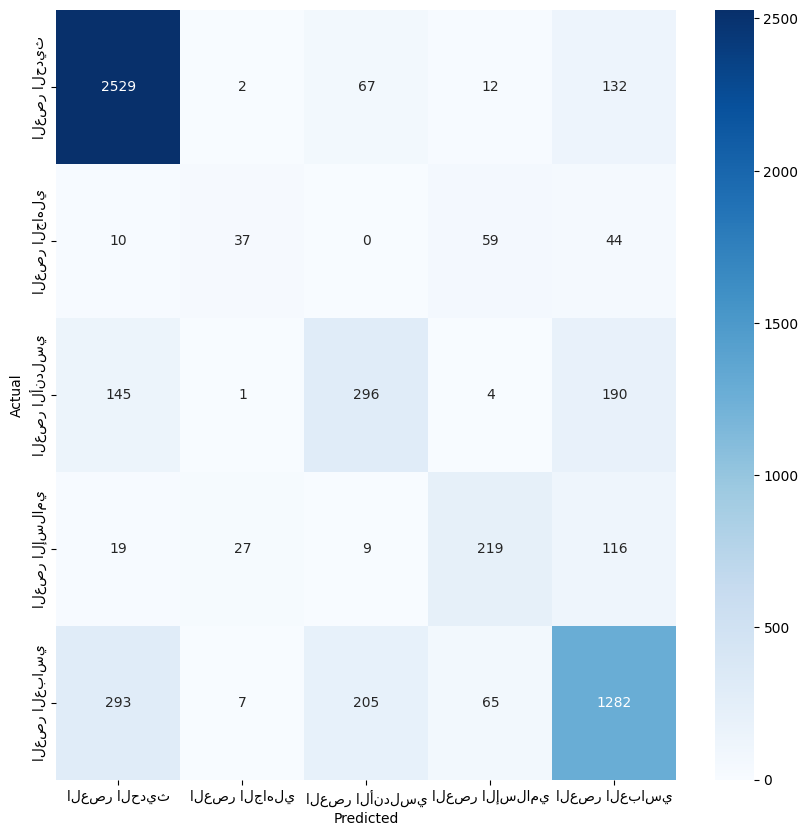

In [ ]:
# Create datasets and data loaders
MAX_LEN = 128
BATCH_SIZE = 16
train_dataset = PoetryDataset(train_texts_resampled, train_labels_resampled, tokenizer, MAX_LEN)
val_dataset = PoetryDataset(val_texts.to_numpy(), val_labels.to_numpy(), tokenizer, MAX_LEN)
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Training settings
EPOCHS = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

# Train and evaluate the model
history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_dataset),
        class_weights
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(val_dataset)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)


# Error Analysis
val_preds = []
val_labels = []
model.eval()
with torch.no_grad():
    for d in val_data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        val_preds.extend(preds)
        val_labels.extend(labels)

# Generate classification report and confusion matrix
val_preds = torch.stack(val_preds).cpu()
val_labels = torch.stack(val_labels).cpu()
label_names = list(label_encoder.keys())
print(classification_report(val_labels, val_preds, target_names=label_names))
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
# model.save_pretrained('/content/arabert_v2_model_v2')
# tokenizer.save_pretrained('/content/arabert_v2_model_v2')

('/content/arabert_v2_model_v2/tokenizer_config.json',
 '/content/arabert_v2_model_v2/special_tokens_map.json',
 '/content/arabert_v2_model_v2/vocab.txt',
 '/content/arabert_v2_model_v2/added_tokens.json')

In [ ]:
# Convert val_labels to a Pandas Series
val_labels_series = pd.Series(val_labels.numpy())

# Display some sample test data
sample_indices = np.random.choice(len(val_texts), 5, replace=False)
sample_test_data = val_texts.iloc[sample_indices].reset_index(drop=True)
sample_test_labels = val_labels_series.iloc[sample_indices].reset_index(drop=True)

# Convert labels back to original text format using label_encoder
reverse_label_encoder = {v: k for k, v in label_encoder.items()}
sample_test_labels_text = sample_test_labels.map(reverse_label_encoder)

# Print the samples
for i, (text, label) in enumerate(zip(sample_test_data, sample_test_labels_text)):
    print(f"Sample {i + 1}:")
    print(f"Poem Text: {text}")
    print(f"Poet Category: {label}")
    print("\n")


Sample 1:
Poem Text: ولي شبابي وراع شيبي مني سرب المها وفضه كانما المشط في يميني تجر منه خيوط فضه
Poet Category: العصر الأندلسي


Sample 2:
Poem Text: منزويا وحزين بين مءات الكتب المرصوفة من يتلفت نحوك يا ابن الصاءغ والناس امام زجاج المكتبة الماع يمرون بحزنك دون مبالاة قد تصفح احداهن اغانيك علي عجل يتقافز قلبك بين اناملها هاهي كالحظ تقطب في وجهك تبتاع دليل الطبخ وتمضي ويضيق ابو المكتبة الكهل بديوانك يرميك بقاع المخزن تبقي بين الاكداس الصفراء المنسية منذ سنين تحلم بالواجهة الماعة بالنظرات وبالمارين فتبكي ايامك ثم تموت بصمت السليمانية
Poet Category: العصر الحديث


Sample 3:
Poem Text: الا انما اودي شبابي وانقضي علي مر ليل داءب ونهار يعيدان لي ما امضيا وهما معا طريدان لا يستلهيان قراري لقد كدت اقضي ما اعتلقت من الصبا علاءقه الا حبال نوار اذا السنة الشهباء حلت عكومها ضربنا عليها ام كل حوار
Poet Category: العصر الإسلامي


Sample 4:
Poem Text: دم غمد كل السيوف وقلب فراشة حب تطوف كما يسلك الفجر بين الدجي والصباح ويرجع متشحا بالجراح كاغنية في الخريف ولم يزل العقل ينشر ظل جناحيه في خفية يخرج ال

In [ ]:
val_texts.iloc[2]

'هي الدنيا وزينتها الشباب و في الذات بعدهما ارتياب فلا تذهب بك الاطماع واذهب كءوسك لي فقد حان الذهاب نزلنا منزلا من سرمري به الذات صافية عذاب حديث كابتسام الروض جادت عليه بفيض ادمعها السحاب و اقداح تفوح المسك طيبا ويكمد عندها الذهب المذاب اذا ما الراح والاترج لاحا لعينك قلت ايهما الشراب'

# Gradio Interface

In [2]:
# Define prediction function for Gradio
def classify_poetry(text):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask)
    _, prediction = torch.max(outputs.logits, dim=1)
    return label_names[prediction.item()]

# Set up Gradio interface
interface = gr.Interface(
    fn=classify_poetry,
    inputs=gr.Textbox(lines=2, placeholder="Enter Arabic poetry here..."),
    outputs="label",
    title="Arabic Poetry Classifier",
    description="Classify Arabic poetry into different categories."
)

# Launch the interface
interface.launch()